# scikit-learnの様々な分類アルゴリズムを試す
参考URL<br>
[機械学習 iris データセットを用いて scikit-learn の様々な分類アルゴリズムを試してみた](https://qiita.com/ao_log/items/fe9bd42fd249c2a7ee7a)<br>
[EMアルゴリズム徹底解説](https://qiita.com/kenmatsu4/items/59ea3e5dfa3d4c161efb)

# irisデータセットのロード

In [1]:
import os
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as ani
from matplotlib import font_manager
from matplotlib import rc
import scipy as sp
from scipy import stats as st
from collections import Counter
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from IPython.display import display

# JupyterLab で実行する際は、この行を書くことで描画できるようになります。
%matplotlib inline

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)

sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# %config InlineBackend.figure_format='retina'
# OS判別 ======================
flag_win32 = False
try:
    os.uname()
except AttributeError:
    flag_win32 = True

# Mac用フォント設定（yasubeiの環境では上手く行かなかったのでコメントアウトしておきます）
# if not flag_win32:
#     font_path = '/Library/Fonts/Osaka.ttf'
#     font_prop = font_manager.FontProperties(fname=font_path)
#     matplotlib.rcParams['font.family'] = font_prop.get_name()
#     plt.rcParams['font.family'] = 'Osaka'

In [2]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

target の行が 0, 1, 2 だと分かりにくいので種類名に置き換えます。<br>
今回は勉強会用にわかりやすさを重視して置き換えておきます。

In [3]:
df.loc[df['target'] == 0, 'target'] = "setosa"
df.loc[df['target'] == 1, 'target'] = "versicolor"
df.loc[df['target'] == 2, 'target'] = "virginica"

In [4]:
pd.concat([df.head(),df.tail()])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


# ペアプロット
ペアプロットします。各特徴量のペアごとに散布図を表示させることができます。<br>

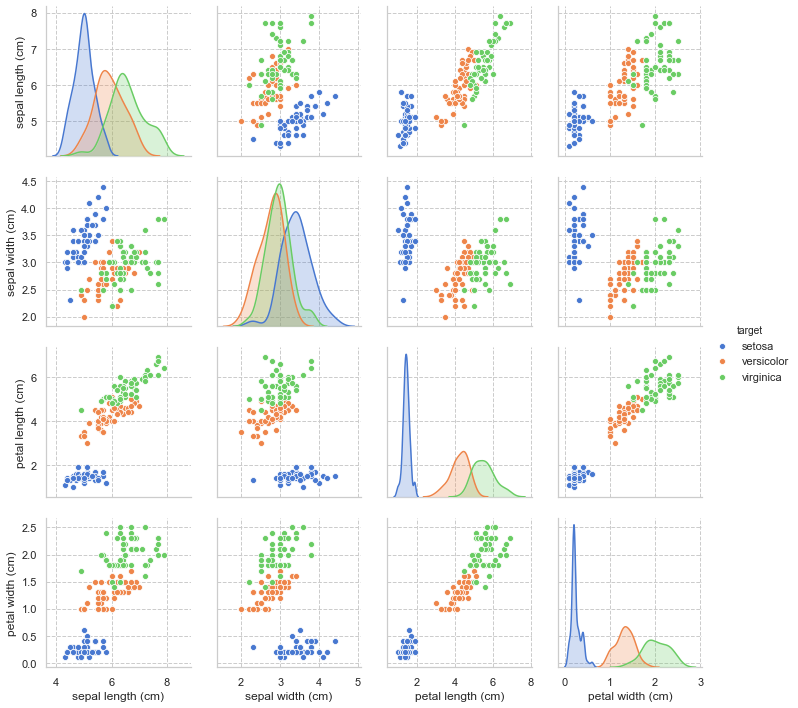

In [5]:
sns.pairplot(df, hue="target")

## 分類アルゴリズム

学習データの定義

In [6]:
# import some data to play with
X = iris.data[:, [0, 2]]   # sepal length, petal length (比較的分類が簡単な組み合わせ。100%になってしまうこともある)
# X = iris.data[:, [0, 1]]   # sepal length, sepal width (分類が難しい組み合わせ。77%ほどしか精度が出ない)
y = iris.target

In [7]:
def decision_boundary(clf, X, y, ax, title, report_type="classification"):

    # graph common settings
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # データを訓練データとテストデータに分ける
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
    
    # 学習する
    clf.fit(X_train, y_train)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)

    # label
    ax.set_title(title)
    ax.set_xlabel('sepal length')
    ax.set_ylabel('petal length')
    
    # 学習データによる精度表示
    if report_type is "classification":
#         print('train classification_report')
        y_true = y_test
        y_pred = clf.predict(X_test)
        report_dict = classification_report(y_true, y_pred,
                                   target_names=["setosa","versicolor","virginica"],
                                   output_dict=True)
        df_report = pd.DataFrame(report_dict)
        display(df_report)
    elif report_type is "regression":
        print('Test score: {:.3f}'.format(clf.score(X_test, y_test)))    

# 教師なし学習
## k-means(scikit-learn)
教師データなしで分類する手法です。KMeans を使います。n_clustersで何個に分類するかを指定します。

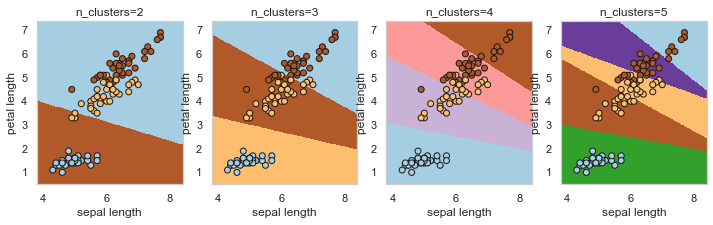

In [8]:
from sklearn.cluster import KMeans

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for ax, n_clusters in zip(axes, [2, 3, 4, 5]):
    title = "n_clusters=%s"% (n_clusters)
    clf = KMeans(n_clusters=n_clusters)
    decision_boundary(clf, X, y, ax, title, report_type=False)

## k-means(hand-coding)

In [9]:
## 定数定義
K_MEANS_GIF = "image/k-means_iris_anim.gif"

In [10]:
# データを訓練データとテストデータに分ける
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [11]:
df_kmeans = pd.DataFrame(X_train_kmeans)
df_kmeans.loc[:,"target"] = y_train_kmeans
pd.concat([df_kmeans.head(),df_kmeans.tail()])

,0,1,target
0,7.7,6.9,2
1,5.7,1.7,0
2,5.0,1.4,0
3,4.8,1.4,0
4,5.2,3.9,1
100,6.3,5.1,2
101,6.4,5.5,2
102,6.3,4.9,1
103,6.7,5.6,2
104,4.9,1.4,0


## Data initialization for hand-conding

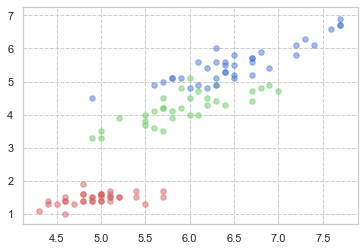

In [12]:
K = 3
c = ['r', 'g', 'b']
color_dict = {0: 'r', 1: 'g', 2: 'b'}
n = [len(df_kmeans[df_kmeans["target"] == 0]),
     len(df_kmeans[df_kmeans["target"] == 1]),
     len(df_kmeans[df_kmeans["target"] == 2])]
N = np.sum(n)

rd.seed(71)
org_data = df_kmeans.values

# plot generated data        
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)
    
# drop true cluster label
data = org_data[:,0:2].copy()

# Initialize(k-means)

init mu:
 [[4.93095593 2.17231495]
 [5.61443763 6.407692  ]
 [7.12844708 5.65103313]]


Text(0.5, 1.0, 'initial state')

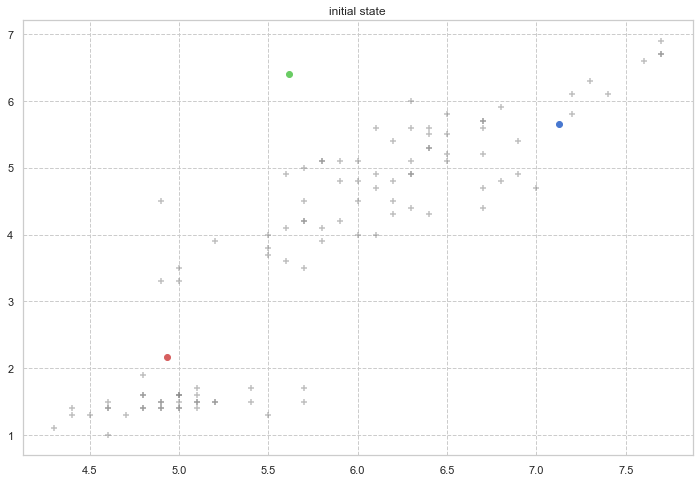

In [13]:
# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visalize for check
plt.figure(figsize=(12,8))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
plt.title('initial state')

In [14]:
# for _iter in range(100):
def k_means_animate(nframe):
    global mu
    print('nframe:', nframe)
    plt.clf()
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    
    if nframe <= 3:
        print('initial state')
        plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
        for i in range(3):
            plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
        plt.title('initial state')
        return

    # Step 1
    # calculate nearest mu[k]
    r = np.zeros(N)
    for i in range(N):
        r[i] = np.argmin([np.linalg.norm(data[i]-mu[k]) for k in range(K)])

    # Step 2
    cnt = dict(Counter(r))
    N_k = [cnt[k] for k in range(K)]
    mu_prev = mu.copy()
    mu = np.asanyarray([np.sum(data[r == k],axis=0)/N_k[k] for k in range(K)])
    diff = mu - mu_prev
    print('diff:\n', diff)

    # visualize
    #plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=color_dict[r[i]], alpha=0.5, marker="+")

    ax = plt.axes()
    for i in range(K):
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8,head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
    plt.title("iter:{}".format(nframe))
    
    if np.abs(np.sum(diff)) < 0.0001:
        plt.title('mu is converged.')
    else:
        plt.title("iter:{}".format(nframe))

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


nframe: 0
initial state
nframe: 0
initial state
nframe: 1
initial state
nframe: 2
initial state
nframe: 3
initial state
nframe: 4
diff:
 [[ 0.11585258 -0.18295325]
 [ 0.14806237 -1.245192  ]
 [-0.61444708 -0.49703313]]


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


nframe: 5
diff:
 [[-0.08430851 -0.3268617 ]
 [-0.00324074 -0.70694444]
 [ 0.19652632  0.25915789]]
nframe: 6
diff:
 [[-0.02083333 -0.19305556]
 [ 0.01851852 -0.15      ]
 [ 0.05007974  0.1807815 ]]
nframe: 7
diff:
 [[0.         0.        ]
 [0.02748538 0.03128655]
 [0.02971652 0.04477028]]
nframe: 8
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 9
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 10
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 11
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 12
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 13
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 14
diff:
 [[0. 0.]
 [0. 0.]
 [0. 0.]]
nframe: 0
initial state


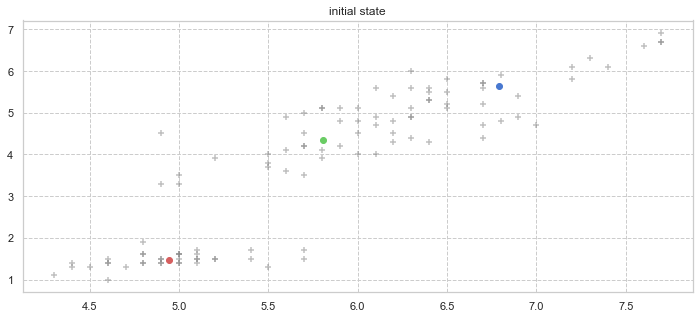

In [15]:
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, k_means_animate, frames=15)
anim.save(K_MEANS_GIF, writer='imagemagick', fps=2, dpi=128)

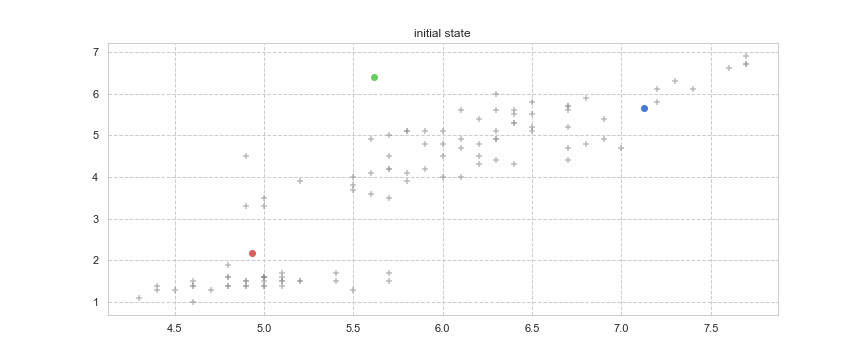

In [16]:
from IPython.display import Image as display_Image
display_Image(K_MEANS_GIF)

# GGM(hand-conding)

In [17]:
# 定数定義
GMM_GIF = "image/gmm_iris_anim.gif"

In [18]:
def calc_likelihood(data, mu, sigma, pi, K):
    likelihood = np.zeros((np.sum(n), 3))
    for k in range(K):
        likelihood[:, k] = [pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for d in data]
    return likelihood

def calc_prob_gmm(data, mu, sigma, pi, K):
    return [[pi[k]*st.multivariate_normal.pdf(d, mu[k], sigma[k]) for k in range(K)] for d in data]

def print_gmm_contour(mu, sigma, pi, K):
    # display predicted scores by the model as a contour plot
    X, Y = np.meshgrid(np.linspace(min_x, max_x), np.linspace(min_y, max_y))
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = np.sum(np.asanyarray(calc_prob_gmm(XX, mu, sigma, pi, K)), axis=1)
    Z = Z.reshape(X.shape)
    CS = plt.contour(X, Y, Z, alpha=0.2, zorder=-100)
    
    plt.title('pdf contour of a GMM')

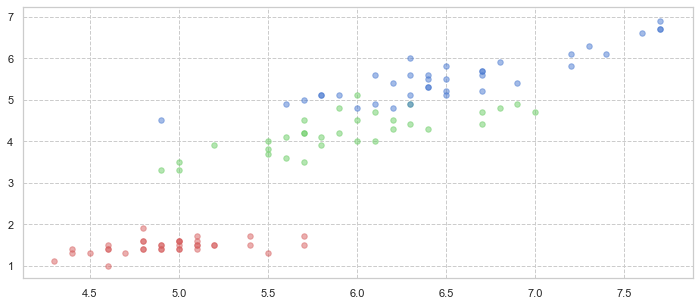

In [19]:
plt.figure(figsize=(12, 5))
for i in range(3):
    plt.scatter(org_data[org_data[:,2]==i][:,0], org_data[org_data[:,2]==i][:,1], s=30, c=c[i], alpha=0.5)

## Initialize(GMM)

init pi: [0.33333333 0.33333333 0.33333333]
init mu:
 [[6.75685457 2.37898688]
 [7.68536137 2.90224515]
 [7.17426528 5.22827044]]


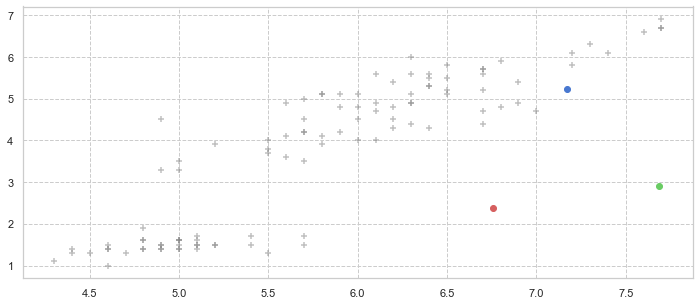

initial sum of log likelihood: -12144.02742067167
pi:
 [0.33333333 0.33333333 0.33333333]
mu:
 [[6.75685457 2.37898688]
 [7.68536137 2.90224515]
 [7.17426528 5.22827044]]
sigma:
 [[[0.1 0. ]
  [0.  0.1]]

 [[0.1 0. ]
  [0.  0.1]]

 [[0.1 0. ]
  [0.  0.1]]]


Text(0.5, 1.0, 'initial state')

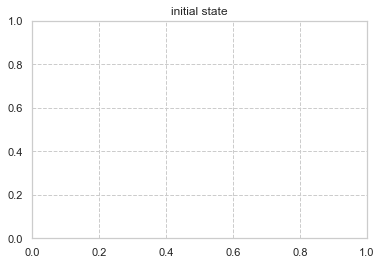

In [20]:
# initialize pi
K = 3
pi = np.zeros(K)
for k in range(K):
    if k == K-1:
        pi[k] = 1 - np.sum(pi)
    else:
        pi[k] = 1/K
print('init pi:', pi)

# initialize mu
max_x, min_x = np.max(data[:,0]), np.min(data[:,0])
max_y, min_y = np.max(data[:,1]), np.min(data[:,1])
mu = np.c_[rd.uniform(low=min_x, high=max_x, size=K), rd.uniform(low=min_y, high=max_y, size=K) ]
print('init mu:\n', mu)

# visualize for check
#plt.figure(figsize=(12,8))
plt.figure(figsize=(12, 5))
plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")

for i in range(3):
    plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    
plt.show()

# initialize sigma
sigma = np.asanyarray(
        [ [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]],
          [[0.1,  0],[ 0, 0.1]] ])

# calculate likelihood
likelihood = calc_likelihood(data, mu, sigma, pi, K)
print('initial sum of log likelihood:', np.sum(np.log(likelihood)))

print('pi:\n', pi)
print('mu:\n', mu)
print('sigma:\n', sigma)

plt.title('initial state')

# EM algorithm started

In [21]:
#for step in range(100):
def animate(nframe):
    global mu, sigma, pi
    print('nframe:', nframe)
    plt.clf()
    
    if nframe <= 3:
        print('initial state')
        plt.scatter(data[:,0], data[:,1], s=30, c='gray', alpha=0.5, marker="+")
        for i in range(3):
            plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        print_gmm_contour(mu, sigma, pi, K)
        plt.title('initial state')
        return

    # E step ========================================================================
    # calculate responsibility(負担率)
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    #gamma = np.apply_along_axis(lambda x: [xx/np.sum(x) for xx in x] , 1, likelihood)
    gamma = (likelihood.T/np.sum(likelihood, axis=1)).T
    N_k = [np.sum(gamma[:,k]) for k in range(K)]

    # M step ========================================================================

    # caluculate pi
    pi =  N_k/N

    # calculate mu
    D = data.shape[1]
    print(f"D={D}")
    tmp_mu = np.zeros((K, D))

    for k in range(K):
        for i in range(len(data)):
            tmp_mu[k] += gamma[i, k]*data[i]
        tmp_mu[k] = tmp_mu[k]/N_k[k]
#         print('updated mu[{}]:\n'.format(k) , tmp_mu[k])
    mu_prev = mu.copy()
    mu = tmp_mu.copy()
#     print('updated mu:\n', mu)

    # calculate sigma
    tmp_sigma = np.zeros((K, D, D))

    for k in range(K):
        tmp_sigma[k] = np.zeros((D, D))
        for i in range(N):
            tmp = np.asanyarray(data[i]-mu[k])[:,np.newaxis]
            tmp_sigma[k] += gamma[i, k]*np.dot(tmp, tmp.T)
        tmp_sigma[k] = tmp_sigma[k]/N_k[k]

#         print('updated sigma[{}]:\n'.format(k) , tmp_sigma[k])
    sigma = tmp_sigma.copy()

    # calculate likelihood
    prev_likelihood = likelihood
    likelihood = calc_likelihood(data, mu, sigma, pi, K)
    
    prev_sum_log_likelihood = np.sum(np.log(prev_likelihood))
    sum_log_likelihood = np.sum(np.log(likelihood))
    diff = prev_sum_log_likelihood - sum_log_likelihood
    
    print('sum of log likelihood:', sum_log_likelihood)
    print('diff:', diff)

    print('pi:', pi)
    print('mu:', mu)
    print('sigma:', sigma)

    # visualize
    #plt.figure(figsize=(12,8))
    for i in range(N):
        plt.scatter(data[i,0], data[i,1], s=30, c=[gamma[i]], alpha=0.5, marker="+")

    for i in range(K):
        ax = plt.axes()
        ax.arrow(mu_prev[i, 0], mu_prev[i, 1], mu[i, 0]-mu_prev[i, 0], mu[i, 1]-mu_prev[i, 1],
                  lw=0.8, head_width=0.02, head_length=0.02, fc='k', ec='k')
        plt.scatter([mu_prev[i, 0]], [mu_prev[i, 1]], c=c[i], marker='o', alpha=0.8)
        plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o', edgecolors='k', linewidths=1)
        #plt.scatter([mu[i, 0]], [mu[i, 1]], c=c[i], marker='o')
    plt.title("step:{}".format(nframe))
    
    print_gmm_contour(mu, sigma, pi, K)
    # plt.show()
    
    if np.abs(diff) < 0.0001:
        plt.title('likelihood is converged.')
    else:
        plt.title("iter:{}".format(nframe-3))

In [22]:
fig = plt.figure(figsize=(12,5))
anim = ani.FuncAnimation(fig, animate, frames=15)
anim.save(GMM_GIF, writer='imagemagick', fps=2, dpi=128)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


nframe: 0
initial state
nframe: 0
initial state
nframe: 1
initial state
nframe: 2
initial state
nframe: 3
initial state
nframe: 4
D=2
sum of log likelihood: -inf
diff: inf
pi: [4.37084387e-01 8.27245175e-05 5.62832889e-01]
mu: [[5.03685709 1.93920732]
 [6.00650735 3.98194577]
 [6.39261065 5.13503857]]
sigma: [[[0.14239453 0.19309035]
  [0.19309035 0.8365982 ]]

 [[0.01967223 0.0061442 ]
  [0.0061442  0.00514294]]

 [[0.34116787 0.31458074]
  [0.31458074 0.51599757]]]


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log
/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


nframe: 5
D=2
sum of log likelihood: -inf
diff: nan
pi: [3.97027355e-01 4.66602589e-04 6.02506043e-01]
mu: [[4.99664076 1.76518527]
 [6.01838634 3.98681954]
 [6.32921244 5.03797128]]
sigma: [[[0.13165163 0.13427827]
  [0.13427827 0.59182904]]

 [[0.00958442 0.0029205 ]
  [0.0029205  0.00117298]]

 [[0.38041593 0.38231776]
  [0.38231776 0.61478692]]]


/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log
/Users/suzuki_yasuharu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars


nframe: 6
D=2
sum of log likelihood: -inf
diff: nan
pi: [0.36201084 0.00445475 0.63353441]
mu: [[4.9573646  1.57690635]
 [6.04666882 3.99635036]
 [6.27975974 4.97121427]]
sigma: [[[1.15287288e-01 5.70535843e-02]
  [5.70535843e-02 2.35427014e-01]]

 [[4.67871730e-03 9.00262214e-04]
  [9.00262214e-04 3.51647358e-04]]

 [[4.12903616e-01 4.30018294e-01]
  [4.30018294e-01 6.77326595e-01]]]
nframe: 7
D=2
sum of log likelihood: -inf
diff: nan
pi: [0.34305558 0.01564879 0.64129563]
mu: [[4.94175439 1.47059755]
 [6.05233101 3.99999928]
 [6.25295376 4.94468267]]
sigma: [[[1.10748010e-01 2.55871263e-02]
  [2.55871263e-02 2.92923938e-02]]

 [[2.49499751e-03 1.81300736e-07]
  [1.81300736e-07 7.18498435e-08]]

 [[4.41583404e-01 4.67054832e-01]
  [4.67054832e-01 7.17678162e-01]]]
nframe: 8
D=2


LinAlgError: singular matrix

<Figure size 864x360 with 0 Axes>

In [ ]:
display_Image(GMM_GIF)